# Import all necessary **Library**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import torch
import pickle
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

2025-08-13 18:44:30.682838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755110670.879660      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755110670.933014      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Dataset

In [3]:
movie_review = pd.read_csv("/kaggle/input/imdb-movie-reviews-dataset/train_data (1).csv",encoding='ISO-8859-1') # Load the datasets with proper encoding

In [4]:
movie_review.rename(columns={'0': 'Reviews', '1': 'Sentiment'}, inplace=True) 

In [5]:
movie_review.head()

,Reviews,Sentiment
0,"This film is absolutely awful, but nevertheles...",0
1,Well since seeing part's 1 through 3 I can hon...,0
2,I got to see this film at a preview and was da...,1
3,This adaptation positively butchers a classic ...,0
4,RÃ¥zone is an awful movie! It is so simple. It...,0


# Data visualizing

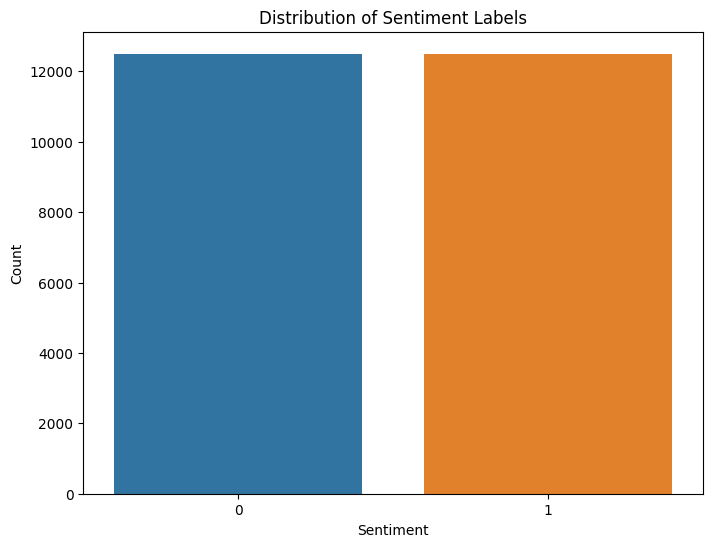

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=movie_review)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Pre-processing data 

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_data(texts, labels, max_length=256):
    encoded = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
        'labels': torch.tensor(labels)
    }

# Preprocess training and testing data
train_data = preprocess_data(movie_review['Reviews'].tolist(), movie_review['Sentiment'].tolist())
test_data = preprocess_data(movie_review['Reviews'].tolist(), movie_review['Sentiment'].tolist())

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Initalizing all the model & dataset

In [8]:
# Initialize model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create DataLoader
train_dataset = TensorDataset(train_data['input_ids'], train_data['attention_mask'], train_data['labels'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model Build

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"Data passes through {epoch+1}/{num_epochs} times or epochs. ")

# Save the model
torch.save(model.state_dict(), 'bert_sentiment_v1_model.pth')

Data passes through 1/1 times or epochs. 


# Data Evaluation

In [10]:
model.eval()
test_dataset = TensorDataset(test_data['input_ids'], test_data['attention_mask'], test_data['labels'])
test_loader = DataLoader(test_dataset, batch_size=32)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy}")
print(classification_report(all_labels, all_preds))

Accuracy: 0.95648
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     12500
           1       0.95      0.96      0.96     12500

    accuracy                           0.96     25000
   macro avg       0.96      0.96      0.96     25000
weighted avg       0.96      0.96      0.96     25000



# Make Prediction

In [11]:
def predict_sentiment(text):
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1)
    return "Positive" if pred.item() == 1 else "Negative"

# Test with new sentences
print(predict_sentiment("I love this movie!"))  
print(predict_sentiment("This movie was terrible."))

Positive
Negative


# Plotting Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

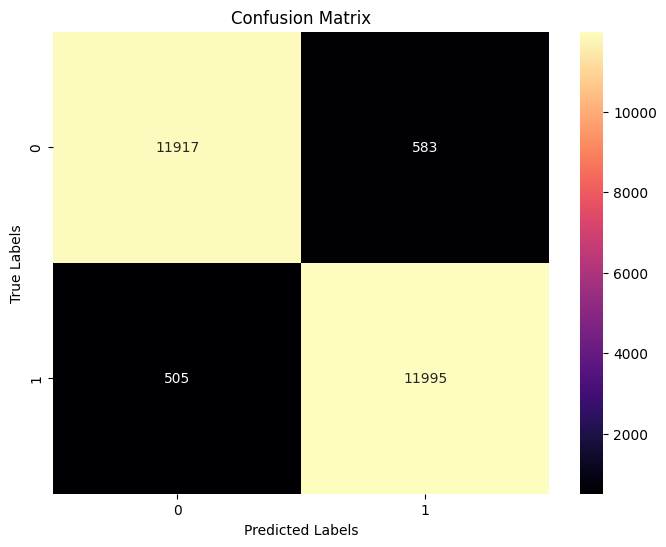

In [25]:
cm = confusion_matrix(all_labels, all_preds)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
